In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib inline

# Center calibration from field rastering at $\phi = 0^\circ,90^\circ$

In [2]:
lox = 10.0
hix = 14.0
stepx = 0.05
loy = 11.0
hiy = 15.0
stepy = 0.05
xpts = np.arange(lox, hix + stepx, stepx)
ypts = np.arange(loy, hiy + stepy, stepy)

In [3]:
phi0 = pd.read_csv('./2019-02-05/probe_wire_side_1.55mm_shim_fieldRaster_2019-02-05_1.csv', comment='#')
phi90 = pd.read_csv('./2019-02-05/probe_wire_side_1.55mm_shim_fieldRaster_2019-02-05_2.csv', comment='#')
phi0_dv = {}
phi90_dv = {}
for c in phi0.columns[:]:
    phi0_dv[c] = (["Ycoord", "Xcoord"], phi0[c].values.reshape(xpts.size, ypts.size))
    phi90_dv[c] = (["Ycoord", "Xcoord"], phi90[c].values.reshape(xpts.size, ypts.size))
coords = {'Xcoord': ('Xcoord', xpts), 'Ycoord': ('Ycoord', ypts)}
phi0_ds = xr.Dataset(phi0_dv, coords)
phi90_ds = xr.Dataset(phi90_dv, coords)

In [4]:
#phi0_ds.X.hvplot()

In [5]:
phi0_ds.Yfield_avg.hvplot()

:Image   [Ycoord,Xcoord]   (Yfield_avg)

In [6]:
phi90_ds.Xfield_avg.hvplot()

:Image   [Ycoord,Xcoord]   (Xfield_avg)

In [7]:
phi0_ds.Zfield_avg.hvplot()

:Image   [Ycoord,Xcoord]   (Zfield_avg)

In [8]:
phi90_ds.Zfield_avg.hvplot()

:Image   [Ycoord,Xcoord]   (Zfield_avg)

## Correct center position should have the minimum Z field in both directions. To combine into one, look at $Z_{\phi=0}^2 + Z_{\phi=90}^2$ and look for a minimum

In [9]:
Zfield_mod = (phi90_ds.Zfield_avg**2 + phi0_ds.Zfield_avg**2)

In [10]:
Zfield_mod.hvplot(title = "Combined 0 and 90 Z field")

:Image   [Ycoord,Xcoord]   (Zfield_avg)

In [11]:
Zfield_mod.where(Zfield_mod == Zfield_mod.min(), drop=True)

<xarray.DataArray 'Zfield_avg' (Ycoord: 1, Xcoord: 1)>
array([[3.810781e-07]])
Coordinates:
  * Xcoord   (Xcoord) float64 11.95
  * Ycoord   (Ycoord) float64 14.45

# Similar logic can be applied to the "Y field" (Note that this depends on $\phi$, so for $\phi=0$ this means Y field, for $\phi=90$ this means X field. Now we look for the maximum

In [12]:
Yfield_mod = (phi90_ds.Xfield_avg**2 + phi0_ds.Yfield_avg**2)

In [13]:
Yfield_mod.hvplot(title="Combined 0 and 90 Y field")

:Image   [Ycoord,Xcoord]   (value)

In [14]:
Yfield_mod.where(Yfield_mod == Yfield_mod.max(), drop=True)

<xarray.DataArray (Ycoord: 1, Xcoord: 1)>
array([[0.090482]])
Coordinates:
  * Xcoord   (Xcoord) float64 11.9
  * Ycoord   (Ycoord) float64 14.5

# From these, seems like the best point is $(11.925,14.475)$ with pretty strong corroboration beetween $Y$ maximum and $Z$ minimum field strength points

In [15]:
phi0_phi = np.arctan2(phi0_ds.Xfield_avg, phi0_ds.Yfield_avg)
phi90_phi = np.arctan2(phi90_ds.Yfield_avg, phi90_ds.Xfield_avg)
theta0_phi = np.arctan2(np.sqrt(phi0_ds.Xfield_avg**2 + phi0_ds.Yfield_avg**2), phi0_ds.Zfield_avg)
theta90_phi = np.arctan2(np.sqrt(phi90_ds.Xfield_avg**2 + phi90_ds.Yfield_avg**2), phi90_ds.Zfield_avg)

## Can see that we are slightly off on our field angle, by about $3.2^\circ$, but I guess that's not too bad

In [16]:
phi0_phi.sel(Xcoord=phi90_ds.Yfield_avg.Xcoord[39].values, Ycoord=phi90_ds.Yfield_avg.Ycoord[70].values)*180/np.pi

<xarray.DataArray ()>
array(3.117929)
Coordinates:
    Xcoord   float64 11.95
    Ycoord   float64 14.5

In [17]:
phi90_phi.sel(Xcoord=phi90_ds.Yfield_avg.Xcoord[39].values, Ycoord=phi90_ds.Yfield_avg.Ycoord[70].values)*180/np.pi

<xarray.DataArray ()>
array(-3.625553)
Coordinates:
    Xcoord   float64 11.95
    Ycoord   float64 14.5

## Also we're just barely off in $\theta$, but I guess that's what we were calibrating for

In [18]:
(90-theta0_phi.sel(Xcoord=phi90_ds.Yfield_avg.Xcoord[39].values, Ycoord=phi90_ds.Yfield_avg.Ycoord[70].values)*180/np.pi)

<xarray.DataArray ()>
array(-0.271489)
Coordinates:
    Xcoord   float64 11.95
    Ycoord   float64 14.5

In [19]:
(90-theta90_phi.sel(Xcoord=phi90_ds.Yfield_avg.Xcoord[39].values, Ycoord=phi90_ds.Yfield_avg.Ycoord[70].values)*180/np.pi)

<xarray.DataArray ()>
array(0.113073)
Coordinates:
    Xcoord   float64 11.95
    Ycoord   float64 14.5

## Also did a smaller/finer scan around the center point we found before after removing the shims

In [20]:
lox_fine = 11.43
hix_fine = 12.43
loy_fine = 13.98
hiy_fine = 14.98
step_fine = 0.02
xpts_fine = np.arange(lox_fine, hix_fine+step_fine, step_fine)
ypts_fine = np.arange(loy_fine, hiy_fine+step_fine, step_fine)

In [21]:
phi0_fine = pd.read_csv('./2019-02-07/probe_wire_side_0mm_shim_fieldRaster_2019-02-07_3.csv', comment='#')
phi90_fine = pd.read_csv('./2019-02-07/probe_wire_side_0mm_shim_fieldRaster_2019-02-07_4.csv', comment='#')
phi0_fine_dv = {}
phi90_fine_dv = {}
for c in phi0.columns[:]:
    phi0_fine_dv[c] = (["Ycoord", "Xcoord"], phi0_fine[c].values.reshape(xpts_fine.size, ypts_fine.size))
    phi90_fine_dv[c] = (["Ycoord", "Xcoord"], phi90_fine[c].values.reshape(xpts_fine.size, ypts_fine.size))
coords_fine = {'Xcoord': ('Xcoord', xpts_fine), 'Ycoord': ('Ycoord', ypts_fine)}
phi0_fine_ds = xr.Dataset(phi0_fine_dv, coords_fine)
phi90_fine_ds = xr.Dataset(phi90_fine_dv, coords_fine)

In [22]:
Yfield_mod_fine = (phi0_fine_ds.Yfield_avg**2 + phi90_fine_ds.Xfield_avg**2)
Yfield_mod_fine.hvplot()

:Image   [Ycoord,Xcoord]   (value)

In [23]:
Zfield_mod_fine = (phi0_fine_ds.Zfield_avg**2 + phi90_fine_ds.Zfield_avg**2)
Zfield_mod_fine.hvplot()

:Image   [Ycoord,Xcoord]   (Zfield_avg)

These are a bit noisier than the coarser scans, would probably be best to convolve these with a gaussian or something

In [24]:
Yfield_mod_fine.where(Yfield_mod_fine == Yfield_mod_fine.max(), drop=True)

<xarray.DataArray (Ycoord: 1, Xcoord: 1)>
array([[0.148218]])
Coordinates:
  * Xcoord   (Xcoord) float64 12.03
  * Ycoord   (Ycoord) float64 14.32

In [25]:
Zfield_mod_fine.where(Zfield_mod_fine == Zfield_mod_fine.min(), drop=True)

<xarray.DataArray 'Zfield_avg' (Ycoord: 1, Xcoord: 1)>
array([[7.883442e-08]])
Coordinates:
  * Xcoord   (Xcoord) float64 12.05
  * Ycoord   (Ycoord) float64 14.42

#### About the same as before, shifted slightly. May just round to $(12.00, 14.40)$

# Center Voltage-Field Calibration

In [26]:
vcenter = pd.read_csv('./2019-02-07/probe_wire_side_1.55mm_shim_daedalus_voltCenter_calib_2019-02-07_1.csv',comment="#")

In [27]:
vcenter_nfield = vcenter[vcenter.Yfield<0].reset_index()
vcenter_pfield = vcenter[vcenter.Yfield>0].reset_index()

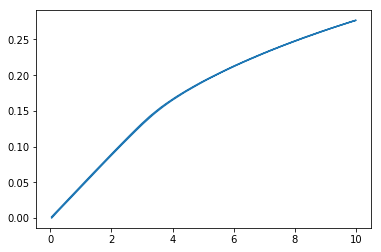

In [28]:
# plt.plot(-vcenter_nfield.V, -vcenter_nfield.Yfield)
plt.plot(vcenter_pfield.V, vcenter_pfield.Yfield)

In [29]:
vcenter_nfield_coeff = np.polyfit(vcenter_nfield.Yfield.values, vcenter_nfield.V.values, 5)
vcenter_pfield_coeff = np.polyfit(vcenter_pfield.Yfield.values, vcenter_pfield.V.values, 5)
vcenter_calib_pfield = np.poly1d(vcenter_pfield_coeff)
vcenter_calib_nfield = np.poly1d(vcenter_nfield_coeff)

In [30]:
# from older calibration used before 2019-02
vcenter_nfield_coeff_old = [1.6183976e3,4.721007,8.11926e1,4.97322391e-1,2.08833e1,2.99493152e-2]
vcenter_pfield_coeff_old = [1.6183976e3,4.721007,8.11926e1,4.97322391e-1,2.08833e1,2.99493152e-2]
vcenter_calib_pfield_old = np.poly1d(vcenter_pfield_coeff_old)
vcenter_calib_nfield_old = np.poly1d(vcenter_nfield_coeff_old)

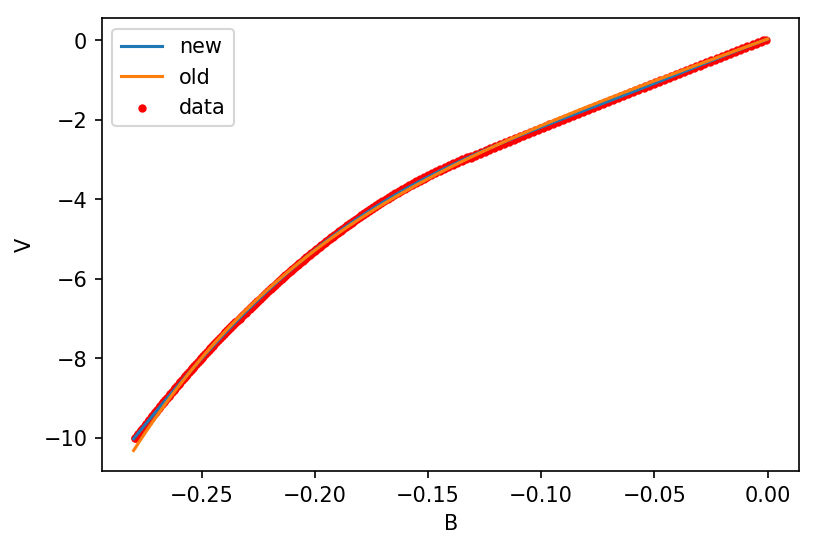

In [31]:
plt.figure(dpi=150)
testfield_neg = np.linspace(-.28,0,100)
plt.plot(testfield_neg, vcenter_calib_nfield(testfield_neg), label='new')
plt.plot(testfield_neg, vcenter_calib_nfield_old(testfield_neg), label='old')
plt.scatter(vcenter_nfield.Yfield, vcenter_nfield.V, c='r', marker='.', label='data')
plt.legend()
plt.xlabel("B")
plt.ylabel("V")
plt.show()

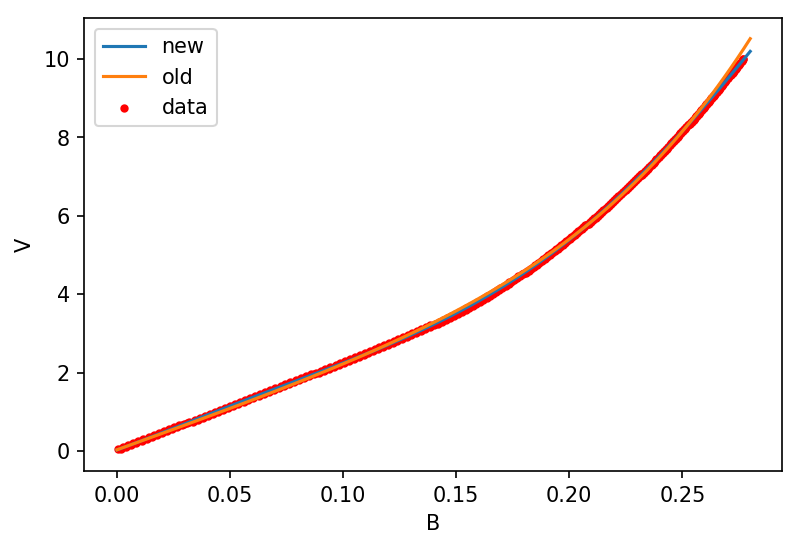

In [32]:
plt.figure(dpi=150)
testfield_pos = np.linspace(0,.28,100)
plt.plot(testfield_pos, vcenter_calib_pfield(testfield_pos), label='new')
plt.plot(testfield_pos, vcenter_calib_pfield_old(testfield_pos), label='old')
plt.scatter(vcenter_pfield.Yfield, vcenter_pfield.V, c='r', marker='.', label='data')
plt.legend()
plt.xlabel("B")
plt.ylabel("V")
plt.show()

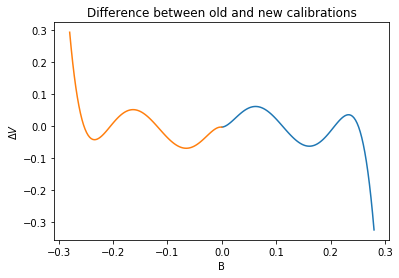

In [33]:
plt.plot(testfield_pos, vcenter_calib_pfield(testfield_pos)-vcenter_calib_pfield_old(testfield_pos))
plt.plot(testfield_neg, vcenter_calib_nfield(testfield_neg)-vcenter_calib_nfield_old(testfield_neg))
plt.title("Difference between old and new calibrations")
plt.xlabel("B")
plt.ylabel("$\Delta V$")
plt.show()

In [34]:
print(vcenter_pfield_coeff,'\n', vcenter_nfield_coeff)

[-1.00526123e+04  6.64542263e+03 -1.11595014e+03  6.67040274e+01
  2.10131713e+01  2.70455248e-02] 
 [-1.03471780e+04 -6.95513423e+03 -1.22184854e+03 -7.87607509e+01
  2.05530573e+01  2.69001607e-02]


# Radial Calibration

In [35]:
r0_vp = pd.read_csv('./2019-02-08/probe_wire_side_1.55mm_shim_daedalus_radialPolar_calib_A000.0_2019-02-08_1.csv',comment='#')
r0_vn = pd.read_csv('./2019-02-08/probe_wire_side_1.55mm_shim_daedalus_radialPolar_calib_A000.0_2019-02-08_2.csv',comment='#')

In [36]:
r0_vp = r0_vp[r0_vp.R<14.2]

In [37]:
r0_vp = r0_vp.assign(phi=lambda x: np.arctan2(x.Xfield, x.Yfield)*180/np.pi)
r0_vp = r0_vp.assign(theta= lambda x: 90-np.arctan2(x.Yfield, x.Zfield)*180/np.pi)
r0_vp = r0_vp.assign(Bmag = lambda x: np.sqrt(x.Yfield**2 + x.Zfield**2))
r0_vn = r0_vn.assign(phi=lambda x: np.arctan2(x.Xfield, x.Yfield)*180/np.pi)
r0_vn = r0_vn.assign(theta= lambda x: 90+np.arctan2(x.Yfield, x.Zfield)*180/np.pi)
r0_vn = r0_vn.assign(Bmag = lambda x: np.sqrt(x.Yfield**2 + x.Zfield**2))
# r90_vp = r90_vp.assign(phi=lambda x: np.arctan2(x.Yfield, x.Xfield)*180/np.pi)
# r90_vp = r90_vp.assign(theta= lambda x: 90-np.arctan2(x.Xfield, x.Zfield)*180/np.pi)

# r90_vp = r90_vp.assign(Bmag = lambda x: np.sqrt(x.Xfield**2 + x.Zfield**2))

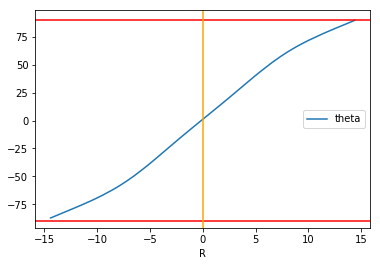

In [38]:
r0_vn.plot('R','theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

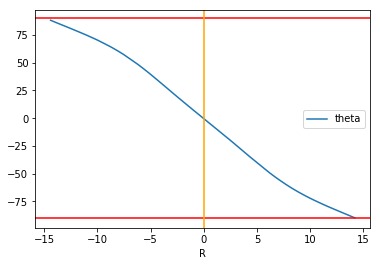

In [39]:
r0_vp.plot('R','theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

In [40]:
r0_vp_rp = r0_vp[r0_vp.R>0]
r0_vp_rn = r0_vp[r0_vp.R<0]
r0_vn_rp = r0_vn[r0_vn.R>0]
r0_vn_rn = r0_vn[r0_vn.R<0]

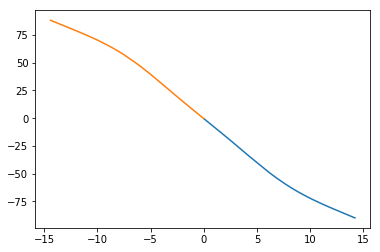

In [41]:
plt.plot(r0_vp_rp.R, r0_vp_rp.theta)
plt.plot(r0_vp_rn.R, r0_vp_rn.theta)

### Basically no discrepancy between positive and negative field $\theta$'s

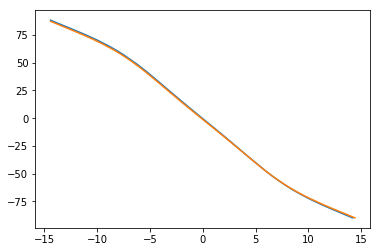

In [42]:
plt.plot(r0_vp.R, r0_vp.theta)
plt.plot(r0_vn.R, -r0_vn.theta)

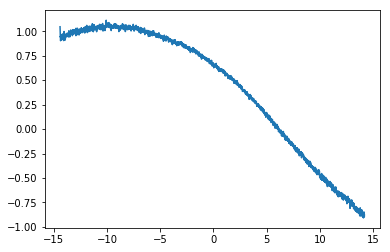

In [43]:
plt.plot(r0_vn.R, r0_vp.theta+r0_vn.theta)

## Will calibrate based on positive and negative thetas

In [44]:
radial_polar_thetaneg_coeff = np.polyfit(r0_vp_rp.theta, r0_vp_rp.R,5)
radial_polar_thetapos_coeff = np.polyfit(r0_vp_rn.theta, r0_vp_rn.R,5)
radial_polar_thetaneg = np.poly1d(radial_polar_thetaneg_coeff)
radial_polar_thetapos = np.poly1d(radial_polar_thetapos_coeff)

In [45]:
r0_vp_rn.theta.max()

88.218913232345

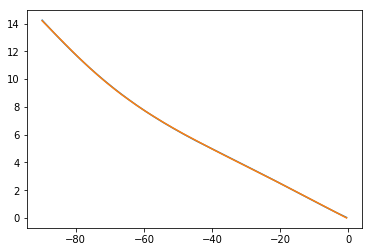

In [46]:
plt.plot(r0_vp_rp.theta, radial_polar_thetaneg(r0_vp_rp.theta))
plt.plot(r0_vp_rp.theta, r0_vp_rp.R)

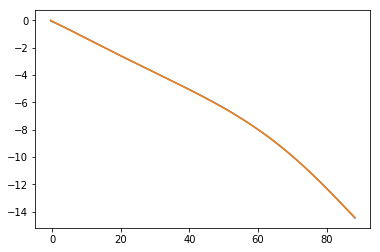

In [47]:
plt.plot(r0_vp_rn.theta, radial_polar_thetapos(r0_vp_rn.theta))
plt.plot(r0_vp_rn.theta, r0_vp_rn.R)

In [48]:
print(radial_polar_thetaneg_coeff,'\n', radial_polar_thetapos_coeff)

[ 3.35571655e-09  8.00745272e-07  5.48653105e-05  1.39606237e-03
 -1.13971700e-01 -1.59524846e-02] 
 [ 4.55107143e-09 -1.01944857e-06  6.63537619e-05 -1.61638296e-03
 -1.12379988e-01 -8.93424587e-02]


### ~40 G difference between strengths though...

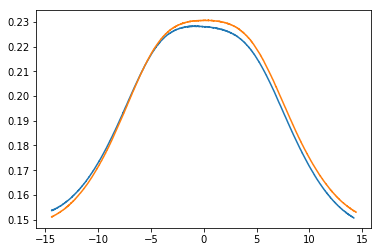

In [49]:
plt.plot(r0_vp.R, r0_vp.Bmag)
plt.plot(r0_vn.R, r0_vn.Bmag)

In [52]:
r0_bmag_vp_rp_coeff = np.polyfit(r0_vp[r0_vp.R>0].R, r0_vp[r0_vp.R>0].Bmag, 5)
r0_bmag_vp_rp = np.poly1d(r0_bmag_vp_rp_coeff)
r0_bmag_vp_rn_coeff = np.polyfit(r0_vp[r0_vp.R<0].R, r0_vp[r0_vp.R<0].Bmag, 5)
r0_bmag_vp_rn = np.poly1d(r0_bmag_vp_rn_coeff)

In [53]:
r0_bmag_vn_rp_coeff = np.polyfit(r0_vn[r0_vn.R>0].R, r0_vn[r0_vn.R>0].Bmag, 5)
r0_bmag_vn_rp = np.poly1d(r0_bmag_vn_rp_coeff)
r0_bmag_vn_rn_coeff = np.polyfit(r0_vn[r0_vn.R<0].R, r0_vn[r0_vn.R<0].Bmag, 5)
r0_bmag_vn_rn = np.poly1d(r0_bmag_vn_rn_coeff)

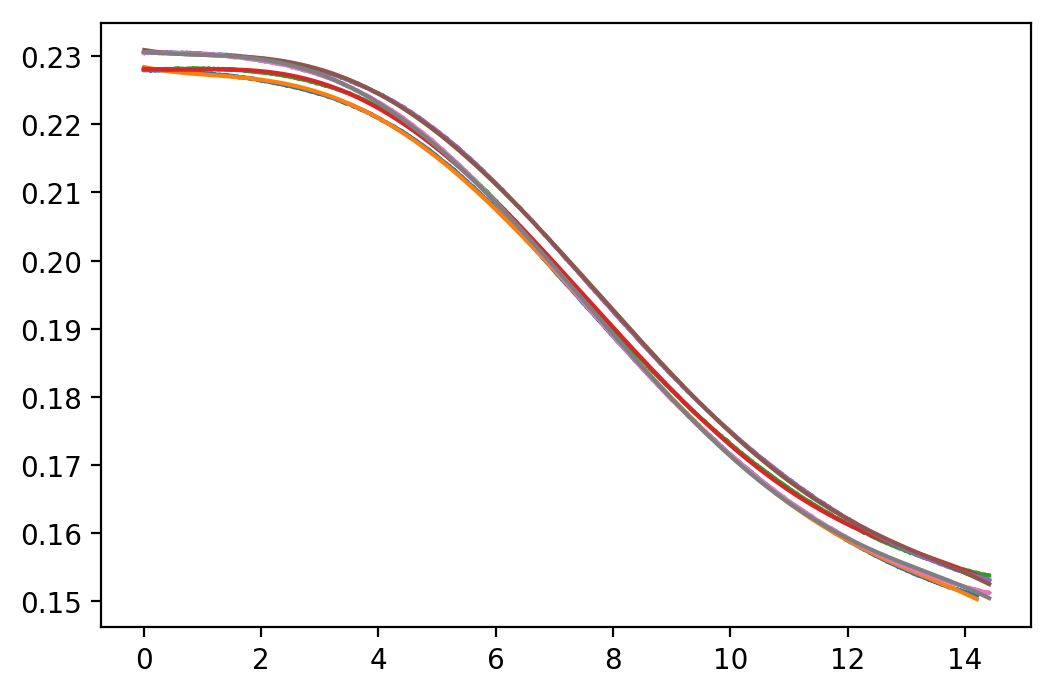

In [54]:
plt.figure(dpi=200)
plt.plot(r0_vp[r0_vp.R>0].R, r0_vp[r0_vp.R>0].Bmag)
plt.plot(r0_vp[r0_vp.R>0].R, r0_bmag_vp_rp(r0_vp[r0_vp.R>0].R))

plt.plot(-r0_vp[r0_vp.R<0].R, r0_vp[r0_vp.R<0].Bmag)
plt.plot(-r0_vp[r0_vp.R<0].R, r0_bmag_vp_rn(r0_vp[r0_vp.R<0].R))

plt.plot(r0_vn[r0_vn.R>0].R, r0_vn[r0_vn.R>0].Bmag)
plt.plot(r0_vn[r0_vn.R>0].R, r0_bmag_vn_rp(r0_vn[r0_vn.R>0].R))

plt.plot(-r0_vn[r0_vn.R<0].R, r0_vn[r0_vn.R<0].Bmag)
plt.plot(-r0_vn[r0_vn.R<0].R, r0_bmag_vn_rn(r0_vn[r0_vn.R<0].R))


# Using radial polar calibration data to get the voltage correction factor as a function of radial position

In [58]:
V0 = 7.0 # voltage used in the radial polar calibration scan
Rpts_pos = np.linspace(0,14.2,100) # radial points to fit to
Rpts_neg = np.linspace(-14.2,0,100)

In [79]:
vcent_vp_rp = V0/vcenter_calib_pfield(r0_bmag_vp_rp(Rpts_pos))
vcent_vp_rn = V0/vcenter_calib_pfield(r0_bmag_vp_rn(Rpts_neg))
vcent_vn_rp = -V0/vcenter_calib_nfield(-r0_bmag_vn_rp(Rpts_pos))
vcent_vn_rn = -V0/vcenter_calib_nfield(-r0_bmag_vn_rn(Rpts_neg))

In [87]:
vcorr_vp_rp_coeff = np.polyfit(Rpts_pos, vcent_vp_rp, 5)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_neg, vcent_vp_rn, 5)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_pos, vcent_vn_rp, 5)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_neg, vcent_vn_rn, 5)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [92]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[ 9.56778016e-06 -3.94118730e-04  5.11242041e-03 -1.78098648e-02
  2.92907842e-02  1.01756708e+00] 
 [-9.97523608e-06 -4.01974044e-04 -5.03733740e-03 -1.59456219e-02
 -1.96390599e-02  1.01941823e+00] 
 [ 9.25358441e-06 -3.85309038e-04  5.03140343e-03 -1.73225138e-02
  2.56810044e-02  1.01622776e+00] 
 [-1.03725231e-05 -4.17639542e-04 -5.22718829e-03 -1.64747328e-02
 -2.35944797e-02  1.01772715e+00]


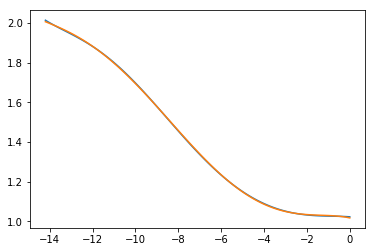

In [88]:
plt.plot(Rpts_neg, vcent_vn_rn)
plt.plot(Rpts_neg, vcorr_vn_rn(Rpts_neg))

In [85]:
rvcorr_pos_coeff_old = [-3.25893000e-06,1.20667061e-04,-1.27497179e-03,1.45375627e-03,-8.52722812e-04,9.97726029e-01]
rvcorr_pos_old = np.poly1d(rvcorr_pos_coeff_old)

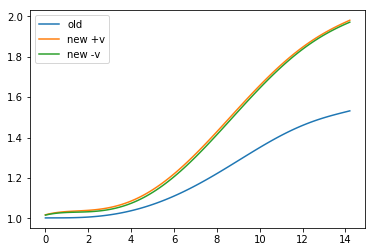

In [91]:
plt.plot(Rpts_pos, 1/rvcorr_pos_old(Rpts_pos), label='old')
plt.plot(Rpts_pos, vcorr_vp_rp(Rpts_pos), label='new +v')
plt.plot(Rpts_pos, vcorr_vn_rp(Rpts_pos), label='new -v')
plt.legend()